In [230]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import functions


In [231]:
path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/'
dfspot1_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover1.csv', index_col = 0)
dfspot2_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover2.csv', index_col = 0)
dfspot3_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover3.csv', index_col = 0)
dfspot4_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover4.csv', index_col = 0)
dfspot5_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover5.csv', index_col = 0)




In [232]:
# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'  # December, January, February (Winter)
    elif month in [3, 4, 5]:
        return 'MAM'  # March, April, May (Spring)
    elif month in [6, 7, 8]:
        return 'JJA'  # June, July, August (Summer)
    else:
        return 'SON'  # September, October, November (Autumn)





def prepare_dfcount_for_plot(dfcount):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 

def prepare_dfcount_for_heatmap(dfcount, temporal_col):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    
    melted = melted.groupby([temporal_col, 'elevation_bin'])['dfs_count'].mean().reset_index()
    toplot = melted.pivot(index="elevation_bin", columns=temporal_col, values="dfs_count")
    return toplot 


In [233]:
dfspot1 = prepare_dfcount_for_heatmap(dfspot1_df, 'season').dropna()
dfspot2 = prepare_dfcount_for_heatmap(dfspot2_df, 'season').dropna()
dfspot3 = prepare_dfcount_for_heatmap(dfspot3_df, 'season').dropna()
dfspot4 = prepare_dfcount_for_heatmap(dfspot4_df, 'season').dropna()
dfspot5 = prepare_dfcount_for_heatmap(dfspot5_df, 'season').dropna()

# Compute global vmin and vmax across all datasets
vmin = min(df.min().min() for df in [dfspot1, dfspot2, dfspot3, dfspot4, dfspot5])
vmax = max(df.max().max() for df in [dfspot1, dfspot2, dfspot3, dfspot4, dfspot5])


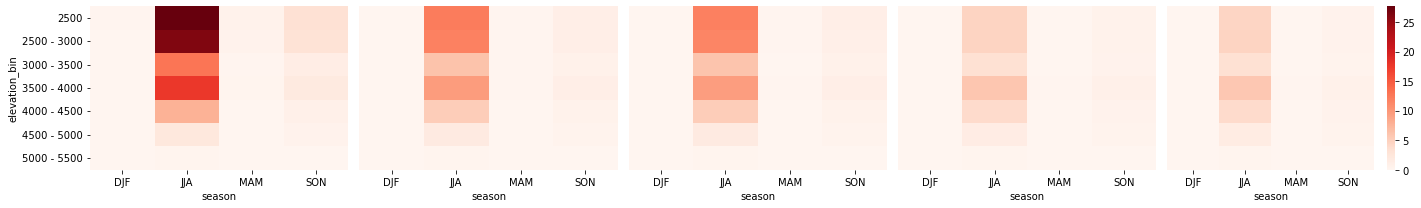

In [234]:
fig = plt.figure(figsize=(20, 3), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.heatmap(dfspot1, ax = mosaic['a'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot2, ax = mosaic['b'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot3, ax = mosaic['c'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot4, ax = mosaic['d'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot5, ax = mosaic['e'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)

mosaic['b'].set_ylabel('')
mosaic['b'].set_yticks([])

mosaic['c'].set_ylabel('')
mosaic['c'].set_yticks([])

mosaic['d'].set_ylabel('')
mosaic['d'].set_yticks([])
mosaic['e'].set_ylabel('')
mosaic['e'].set_yticks([])



testplots = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/'
# plt.savefig(testplots + 'dfspot_count_all_landcovers_seasons.png', dpi = 300, bbox_inches = 'tight')

In [235]:
def prepare_dfcount_for_barplot(dfcount, landcover_idx):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    melted['landcover'] = f'landcover {landcover_idx}'
    return melted 




In [236]:
dfspot1 = prepare_dfcount_for_barplot(dfspot1_df, 1)
dfspot2 = prepare_dfcount_for_barplot(dfspot2_df, 2)
dfspot3 = prepare_dfcount_for_barplot(dfspot3_df, 3)
dfspot4 = prepare_dfcount_for_barplot(dfspot4_df, 4)
dfspot5 = prepare_dfcount_for_barplot(dfspot5_df, 5)


In [237]:
dfspot_all = pd.concat([dfspot1, dfspot2, dfspot3, dfspot4, dfspot5],ignore_index=True)



dfspot_jja = dfspot_all[dfspot_all['season'] == 'JJA']
dfspot_mam = dfspot_all[dfspot_all['season'] == 'MAM']
dfspot_djf = dfspot_all[dfspot_all['season'] == 'DJF']
dfspot_son = dfspot_all[dfspot_all['season'] == 'SON']


In [238]:
dfspot_all.season.unique()

array(['JJA', 'MAM', 'DJF', 'SON'], dtype=object)

<AxesSubplot:xlabel='landcover', ylabel='dfs_count'>

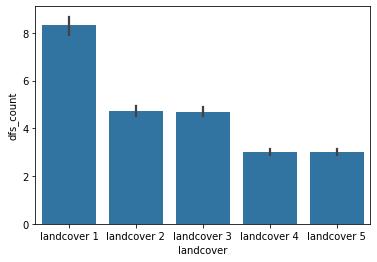

In [239]:
sns.barplot(data = dfspot_jja, x = 'landcover', y ='dfs_count')

/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_16281/2707848643.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(dfspot_all, x='landcover', y='dfs_count', ax=mosaic['a'], palette=color_mapping)#, ci = 'ci')
/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_16281/2707848643.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(dfspot_djf, x='landcover', y='dfs_count', ax=mosaic['b'], palette=color_mapping)#, ci = 'ci')
/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_16281/2707848643.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

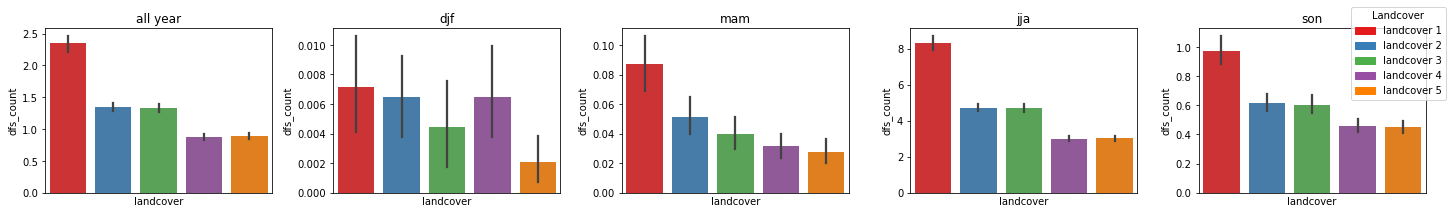

In [240]:
vmax = dfspot_all['dfs_count'].max()

fig = plt.figure(figsize=(20, 3), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')

# Define the color palette
palette = sns.color_palette('Set1')

# Get unique landcover types
landcover_categories = dfspot_all['landcover'].unique()

# Create a dictionary mapping landcover types to colors
color_mapping = dict(zip(landcover_categories, palette[:len(landcover_categories)]))

# Plot barplots with consistent colors
sns.barplot(dfspot_all, x='landcover', y='dfs_count', ax=mosaic['a'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_djf, x='landcover', y='dfs_count', ax=mosaic['b'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_mam, x='landcover', y='dfs_count', ax=mosaic['c'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_jja, x='landcover', y='dfs_count', ax=mosaic['d'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_son, x='landcover', y='dfs_count', ax=mosaic['e'], palette=color_mapping)#, ci = 'ci')

# Create a custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[lc]) for lc in landcover_categories]
fig.legend(handles, landcover_categories, title="Landcover", loc='upper right', bbox_to_anchor=(1.01, 1))

mosaic['a'].set_title('all year')
mosaic['b'].set_title('djf')
mosaic['c'].set_title('mam')
mosaic['d'].set_title('jja')
mosaic['e'].set_title('son')

mosaic['a'].set_xticks([])
mosaic['b'].set_xticks([])
mosaic['c'].set_xticks([])
mosaic['d'].set_xticks([])
mosaic['e'].set_xticks([])



# mosaic['b'].set_ylim([0, 8])
# mosaic['c'].set_ylim([0, 8])
# mosaic['d'].set_ylim([0, 8])
# mosaic['e'].set_ylim([0, 8])

testplots = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/'
# plt.savefig(testplots + 'dfspot_count_all_landcovers_barplots.png', dpi = 300, bbox_inches = 'tight')


# df vs floods

In [258]:
# Define the start and end dates for the filter
start_date = "1990-07-31"
end_date = "2021-06-30"

# Convert column D to datetime if it isn't already


# Filter the DataFrame for the specified date range
def prepare_dfcount_for_plot_floods(dfcount):
    dfcount['D'] = pd.to_datetime(dfcount['D'])
    dfcount = dfcount[(dfcount['D'] >= start_date) & (dfcount['D'] <= end_date)]

    dfcount = dfcount.rename(columns={'D_year': 'year', 'D_month': 'month'})
    dfcount = dfcount.drop('D', axis = 1)
    dfcount['date_id'] = dfcount['year'].astype(str)+ "_" + dfcount['month'].astype(str)
    melted = pd.melt(dfcount, id_vars=['date_id', 'year', 'month'], var_name='elevation', value_name='dfs_count')
    
    # melted = pd.melt(dfcount, id_vars=['date_id'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    # create unique id for elevation and month for merging
    melted['elevation'] = melted['elevation'].astype(int)
    melted['id'] = melted.index.astype(str)+ "_" + melted['elevation'].astype(str) + "_" + melted['year'].astype(str)+ "_" + melted['month'].astype(str)
    
    # melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 




def calculate_floods(df):
    # df percent 
    df[f'dfs_count_60_percent'] = (df[f'dfs_count_60'] *100) / df.dfspot_count
    df[f'dfs_count_50_percent'] = (df[f'dfs_count_50'] *100) / df.dfspot_count
    df[f'dfs_count_40_percent'] = (df[f'dfs_count_40'] *100) / df.dfspot_count
    df[f'dfs_count_30_percent'] = (df[f'dfs_count_30'] *100) / df.dfspot_count
    df[f'dfs_count_20_percent'] = (df[f'dfs_count_20'] *100) / df.dfspot_count
    # ff count 
    df[f'ffs_count_60'] = df.dfspot_count - df[f'dfs_count_60']
    df[f'ffs_count_50'] = df.dfspot_count - df[f'dfs_count_50']
    df[f'ffs_count_40'] = df.dfspot_count - df[f'dfs_count_40']
    df[f'ffs_count_30'] = df.dfspot_count - df[f'dfs_count_30']
    df[f'ffs_count_20'] = df.dfspot_count - df[f'dfs_count_20']
    # ff percent
    df[f'ffs_count_60_percent'] = (df[f'ffs_count_60'] *100) / df.dfspot_count
    df[f'ffs_count_50_percent'] = (df[f'ffs_count_50'] *100) / df.dfspot_count
    df[f'ffs_count_40_percent'] = (df[f'ffs_count_40'] *100) / df.dfspot_count
    df[f'ffs_count_30_percent'] = (df[f'ffs_count_30'] *100) / df.dfspot_count
    df[f'ffs_count_20_percent'] = (df[f'ffs_count_20'] *100) / df.dfspot_count
    return df




import pandas as pd

def merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column):
    """
    Merges a list of dataframes on specified columns and adds a column from a 'dfspot' dataframe.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to merge sequentially.
        dfspot (pd.DataFrame): A dataframe containing a column to add after the merges.
        merge_on (list of str): Columns to use as the merge keys.
        dfspot_column (str): The name of the column in `dfspot` to add after merging.
        
    Returns:
        pd.DataFrame: The merged dataframe with the additional column from `dfspot`.
    """
    
    # Start with the first dataframe in `dfs` and automatically get the count column
    count_column = [col for col in dfs[0].columns if col.startswith('dfs_count')][0]
    merged_df = dfs[0][merge_on + [count_column]]
    
    # Iterate over remaining dataframes and merge each sequentially
    for df in dfs[1:]:
        count_column = [col for col in df.columns if col.startswith('dfs_count')][0]
        merged_df = pd.merge(merged_df, df[merge_on + [count_column]], on=merge_on)
    
    # Add the `dfspot_column` from `dfspot` dataframe to the merged dataframe
    merged_df['dfspot_count'] = dfspot[dfspot_column]
    
    return merged_df

In [259]:
# read data 
# ONCE 20, 30, 40, 50 and 60 percent input 

import glob
import pandas as pd
percentile = '20percent'


# Define the directory path and file pattern (files ending with landcover1, landcover2, etc.)
directory = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percentile}/'
file_pattern = f'langtang_monthly_dfs_count_{percentile}_landcover*.csv'

# Get the list of matching files
files = glob.glob(directory + file_pattern)

# Loop over the files and load them
for file in files:
    df = pd.read_csv(file, index_col = 0).fillna(0)
    # prepare for plot
    prepfile = prepare_dfcount_for_plot_floods(df)
    # calculate floods 
    prepfile_floodscalculate_floods
    
    
    print(f"Processing {file}...")
    print(df.head())


Processing /Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_20percent/langtang_monthly_dfs_count_20percent_landcover3.csv...
           D  4485.0  3734.0  4880.0  4847.0  3908.0  3756.0  4498.0  4933.0  \
0 1990-06-30       4       9     0.0     0.0       6       6       4     0.0   
1 1990-07-31       6      15     0.0     0.0      17      10      14     0.0   
2 1990-08-31       0       0     0.0     0.0       0       0       0     0.0   
3 1990-09-30       0       0     0.0     0.0       0       0       0     0.0   
4 1990-10-31       0       0     0.0     0.0       0       0       0     0.0   

   3695.0  ...  5384.0  5217.0  5870.0  5424.0  5763.0  6335.0  5859.0  \
0       6  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1       4  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2       0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3       0  ...     0.0     0.0     0.0     0.0     0.0  

In [252]:
directory = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_{percentile}/'
file = pd.read_csv(directory + f'langtang_monthly_dfs_count_{percentile}_landcover1.csv', index_col = 0)

In [254]:
file1 = prepare_dfcount_for_plot(file)